In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
import gensim
import pickle
import zipfile
from urllib import request

import numpy as np
import pandas as pd

import seaborn as sns
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Lambda, Add, Concatenate, Multiply, Subtract, Flatten, Dropout

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from gensim.models.doc2vec import Doc2Vec

# Resets notebook state
tf.keras.backend.clear_session()

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
%matplotlib inline

In [2]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']


In [3]:
def download(url, filename, local=True):
    """Download a file if not present"""
    if not local and not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        if os.path.exists(filename):
            print("extracting {}...".format(filename))
            with zipfile.ZipFile(filename) as f:
                f.extractall()
                print("extracting {} done".format(filename))
        else:
            print('data.zip not found!')

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

    return data_path

In [4]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/alodokter-recommender/', filename="data.zip", local=True)

'data'

#### Loading in data

In [5]:
n_tag = 5040
tag_max_len = 5

def load_posts():
    df = pd.read_csv('data/ga-articles.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'title', 'tags']
    return df[['post_id', 'title', 'tags']]

def load_posts_ctr():
    df = pd.read_csv('data/ga-page-clicks.csv', sep=',', header=0, encoding="latin-1")
    df.columns = ['post_id', 'related_post_id', 'ctr']
    return df

def text2seq(text, n_tag):
    """ using tokenizer to encoded the multi-level categorical feature """
    tokenizer = Tokenizer(lower=True, split='|',filters='', num_words=n_tag)
    tokenizer.fit_on_texts(text)
    seq = tokenizer.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen=tag_max_len,padding='post')
    return seq

#### KMeans

In [6]:
print('load kmeans model...')
kmeans_model = pickle.load(open('model/kmeans.pkl', 'rb'))
clusters = kmeans_model.labels_.tolist()
print('load kmeans model done')

load kmeans model...
load kmeans model done


##### Doc3Vec

In [7]:
print('loading doc2vec model...')
doc2vec_model = Doc2Vec.load('model/alodokter-articles-doc2vec.model')
print('loading doc2vec model done')

loading doc2vec model...
loading doc2vec model done


In [8]:
print('loading pid_post_id...')
pid_post_id = pickle.load(open('model/pid_post_id.pkl', 'rb'))
print('loading pid_post_id...')

post_id_pid = {}
for pid, post_id in pid_post_id.items():
    post_id_pid[post_id] = pid

loading pid_post_id...
loading pid_post_id...


In [9]:
# create dictionary doc-id to cluster-id
clusters_docs = {}
docs_clusters = {(idx, cluster) for idx, cluster in enumerate(clusters)}
for item in docs_clusters:
    if item[1] in clusters_docs.keys():
        clusters_docs[item[1]].append(item[0])
    else:
        clusters_docs[item[1]] = [item[0]]

In [10]:
all_posts = load_posts()
all_posts

,post_id,title,tags
0,710,Gejala Rabies,Kesehatan|rabies
1,715,Gejala Dehidrasi,Kesehatan|Dehidrasi|dehydration
2,716,Gejala Autisme,Kesehatan|autism
3,720,Penyebab Dehidrasi,Kesehatan|Dehidrasi|dehydration
4,724,Penyebab Rabies,Kesehatan
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,nutrisi
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,Hidup Sehat
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,Kesehatan
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...",Kesehatan


In [11]:
all_posts['tags'] = text2seq(all_posts.tags.values, n_tag=n_tag).tolist()
all_posts

,post_id,title,tags
0,710,Gejala Rabies,"[1, 530, 0, 0, 0]"
1,715,Gejala Dehidrasi,"[1, 67, 531, 0, 0]"
2,716,Gejala Autisme,"[1, 532, 0, 0, 0]"
3,720,Penyebab Dehidrasi,"[1, 67, 531, 0, 0]"
4,724,Penyebab Rabies,"[1, 0, 0, 0, 0]"
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,"[4, 0, 0, 0, 0]"
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,"[2, 0, 0, 0, 0]"
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,"[1, 0, 0, 0, 0]"
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...","[1, 0, 0, 0, 0]"


In [12]:
# lookup dictionary
post_id_title = {}
for index, row in all_posts.iterrows():
    post_id_title[row.post_id] = row.title
len(post_id_title)

6058

In [13]:
# lookup dictionary
post_id_tags = {}
for index, row in all_posts.iterrows():
    post_id_tags[row.post_id] = row.tags
len(post_id_tags)

6058

In [14]:
pids = clusters_docs[0]
post_ids = [pid_post_id[pid] for pid in pids]
len(post_ids)

531

In [15]:
posts = all_posts
posts

,post_id,title,tags
0,710,Gejala Rabies,"[1, 530, 0, 0, 0]"
1,715,Gejala Dehidrasi,"[1, 67, 531, 0, 0]"
2,716,Gejala Autisme,"[1, 532, 0, 0, 0]"
3,720,Penyebab Dehidrasi,"[1, 67, 531, 0, 0]"
4,724,Penyebab Rabies,"[1, 0, 0, 0, 0]"
...,...,...,...
6053,1618421,Simak Manfaat Sawi Putih dan Cara Mengolahnya,"[4, 0, 0, 0, 0]"
6054,1632238,Terlalu Banyak Berolahraga Ternyata Tidak Sela...,"[2, 0, 0, 0, 0]"
6055,1621149,Tips Aman Berjemur pada Ibu Hamil,"[1, 0, 0, 0, 0]"
6056,1677722,"Yuk, Ikuti Tips Menjalani Hidup dengan HIV/AID...","[1, 0, 0, 0, 0]"


In [16]:
posts.sample(20)

,post_id,title,tags
4760,1252856,Hal-hal Seputar Konsultasi Penyakit Saraf yang...,"[1, 164, 1578, 37, 0]"
1463,92003,Gondongan,"[1, 5, 322, 0, 0]"
1575,106856,Perindopril,"[7, 78, 21, 1147, 0]"
1394,84687,Berbagai Manfaat Kayu Manis untuk Kesehatan da...,"[52, 10, 13, 4, 16]"
4313,1082974,Penyebab Munculnya Jerawat pada Kulit Sensitif...,"[2, 94, 33, 11, 12]"
4605,1192198,Urin berwarna merah setelah konsumsi rifampicin,"[657, 0, 0, 0, 0]"
38,998,Pengobatan Kanker Hati,"[1, 115, 190, 0, 0]"
101,1269,Diagnosis Anemia Defisiensi Besi,"[1, 122, 0, 0, 0]"
2223,274679,Menyingkap Rahasia Mencegah Ejakulasi Dini pad...,"[2, 207, 38, 223, 0]"
5733,1710176,Kapan Gigi Permanen pada Anak Mulai Tumbuh?,"[3, 9, 22, 1736, 0]"


In [17]:
posts_ctr = load_posts_ctr()
print("Total Unique Posts: {}".format(posts_ctr.post_id.nunique()))
posts_ctr[['post_id','related_post_id','ctr']]

Total Unique Posts: 5485


,post_id,related_post_id,ctr
0,35162,16176,23
1,35162,1349929,23
2,35162,795410,23
3,35162,1208332,23
4,35162,100640,23
...,...,...,...
41911,993407,85154,23
41912,993407,1163198,23
41913,993407,48394,23
41914,993407,1194586,23


In [18]:
# do some preprocessing to make sure data quality
dataset_clean_1 = posts_ctr.merge(posts, on='post_id', how='left', indicator=True)
dataset_clean_1 = dataset_clean_1[dataset_clean_1._merge == 'both']
dataset_clean_1 = dataset_clean_1.drop(['_merge'], axis=1)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]"
...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]"


In [19]:
# lookup dictionary
related_post_id_pid = {}
for _, row in dataset_clean_1.iterrows():
    if row.related_post_id not in related_post_id_pid.keys():
        related_post_id_pid[row.related_post_id] = post_id_pid[row.related_post_id]

In [20]:
def pid_column(row):
    if row['post_id'] in post_id_pid.keys():
        return post_id_pid[row['post_id']]
    else:
        return -1

pid = dataset_clean_1.apply(lambda row: pid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(pid=pid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['pid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246
...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096


In [21]:
def nid_column(row):
    if row['related_post_id'] in related_post_id_pid.keys():
        return related_post_id_pid[row['related_post_id']]
    else:
        return -1

nid = dataset_clean_1.apply(lambda row: nid_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(nid=nid.values)
dataset_clean_1 = dataset_clean_1[dataset_clean_1['nid'] != -1]
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822
...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694


In [22]:
# do some preprocessing to make sure data quality
def related_title_column(row):
    if row['related_post_id'] in post_id_title.keys():
        return post_id_title[row['related_post_id']]
    else:
        return 'NONE'

related_title = dataset_clean_1.apply(lambda row: related_title_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_title=related_title.values)

dataset_clean_1 = dataset_clean_1[dataset_clean_1['related_title'] != 'NONE']
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440,bintik-bintik kecil di seluruh tubuh pada anak
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522,Antibiotik
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026,Ini Penyebab Dahak Kental Seperti Jelly
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...
...,...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253,Apakah pengalaman hamil anggur akan mempersuli...
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...


In [23]:
# do some preprocessing to make sure data quality
def related_tags_column(row):
    return post_id_tags[row['related_post_id']]

related_tags = dataset_clean_1.apply(lambda row: related_tags_column(row), axis=1)
dataset_clean_1 = dataset_clean_1.assign(related_tags=related_tags.values)
dataset_clean_1

,post_id,related_post_id,ctr,title,tags,pid,nid,related_title,related_tags
0,35162,16176,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]"
1,35162,1349929,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,522,Antibiotik,"[7, 184, 697, 392, 0]"
2,35162,795410,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...,"[1, 508, 111, 0, 0]"
3,35162,1208332,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,1026,Ini Penyebab Dahak Kental Seperti Jelly,"[1, 23, 44, 43, 62]"
4,35162,100640,23,Mengalami gejala alergi di suhu dingin,"[23, 779, 0, 0, 0]",4246,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...,"[11, 252, 12, 809, 120]"
...,...,...,...,...,...,...,...,...,...
41911,993407,85154,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,5253,Apakah pengalaman hamil anggur akan mempersuli...,"[479, 0, 0, 0, 0]"
41912,993407,1163198,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...,"[1, 166, 58, 582, 51]"
41913,993407,48394,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...,"[176, 154, 125, 101, 177]"
41914,993407,1194586,23,Hamil di Luar Kandungan: Waspadai Penyebab dan...,"[3, 72, 6, 176, 290]",1096,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...,"[3, 72, 6, 176, 0]"


#### Final Dataset

In [24]:
dataset = dataset_clean_1
dataset.columns = ['post_id', 'related_post_id', 'page_view', 'title', 'tags', 'pid', 'nid', 'related_title','related_tags']
dataset = dataset[['post_id','pid','title','related_post_id','nid','related_title','related_tags','page_view']]
dataset

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
0,35162,4246,Mengalami gejala alergi di suhu dingin,16176,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]",23
1,35162,4246,Mengalami gejala alergi di suhu dingin,1349929,522,Antibiotik,"[7, 184, 697, 392, 0]",23
2,35162,4246,Mengalami gejala alergi di suhu dingin,795410,141,Ini Obat Gatal di Selangkangan yang Perlu Dike...,"[1, 508, 111, 0, 0]",23
3,35162,4246,Mengalami gejala alergi di suhu dingin,1208332,1026,Ini Penyebab Dahak Kental Seperti Jelly,"[1, 23, 44, 43, 62]",23
4,35162,4246,Mengalami gejala alergi di suhu dingin,100640,3822,Khasiat Soda Kue Ternyata tidak Hanya Berlaku ...,"[11, 252, 12, 809, 120]",23
...,...,...,...,...,...,...,...,...
41911,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,85154,5253,Apakah pengalaman hamil anggur akan mempersuli...,"[479, 0, 0, 0, 0]",23
41912,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,1163198,1007,Ini Ciri-ciri Kanker Serviks yang Perlu Anda W...,"[1, 166, 58, 582, 51]",23
41913,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,48394,1926,Penyebab Sakit Perut Sebelah Kanan dan Cara Me...,"[176, 154, 125, 101, 177]",23
41914,993407,1096,Hamil di Luar Kandungan: Waspadai Penyebab dan...,1194586,1694,Ketahui Ciri-ciri Hamil di Luar Kandungan Seja...,"[3, 72, 6, 176, 0]",23


In [25]:
dataset.sample(20)

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
16641,1609475,5769,Ini Manfaat Konsumsi Kopi Hitam dan Efek Sampi...,610898,3937,Antisipasi Bahaya Kekurangan Kalium dari Sekarang,"[2, 398, 390, 4, 0]",23
16812,1208332,1026,Ini Penyebab Dahak Kental Seperti Jelly,21374,2692,Melanjutkan minum cefixime setelah sempat berh...,"[768, 0, 0, 0, 0]",23
5144,374787,1540,intaraksi obat antihistamin dengan obat lain,16176,2440,bintik-bintik kecil di seluruh tubuh pada anak,"[9, 0, 0, 0, 0]",45
21370,26569,3104,Cara Menghilangkan Jerawat Batu,77058,4441,Wajah Cantik Bersinar dengan Peeling Wajah,"[2, 487, 11, 171, 114]",23
10740,70749,772,Menghitung Masa Subur Wanita setelah Haid,1217429,2187,"Keluar Darah Haid Menggumpal, Normal atau Berb...","[172, 58, 72, 30, 245]",23
27361,1788567,4712,5 Obat Koreng yang Perlu Anda Ketahui,643483,3319,Koreng Mengganggu Penampilan? Ini Cara Mudah M...,"[2, 139, 0, 0, 0]",23
11230,754968,458,Tubuh menjadi lemas dan mudah lelah setelah ko...,130731,1603,Fakta Suplemen Glukosamin dalam Mengatasi Rada...,"[1, 179, 1169, 0, 0]",23
40809,1209,1740,Diagnosis Gagal Ginjal Kronis,1164353,1221,"Laminektomi, Ini yang Harus Anda Ketahui","[1, 345, 1533, 600, 0]",23
40871,11753,4057,Gejala Gagal Jantung,426591,1009,Endokarditis,"[1, 5, 836, 0, 0]",23
36579,353231,1038,Kenali Penyebab Perdarahan Otak,199625,5034,Delirium,"[1, 5, 1203, 0, 0]",23


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3d8af990>],
      dtype=object)

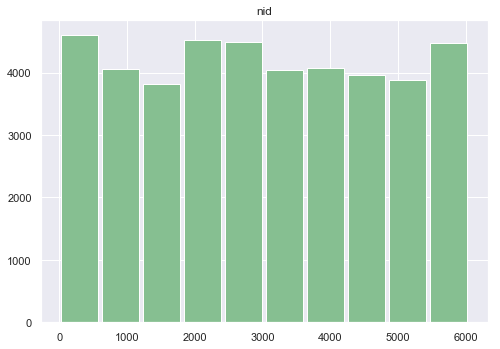

In [26]:
# Histogram
dataset.hist(column='nid', grid=True, figsize=(8,20), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)

In [27]:
num_pid = len(dataset.pid.unique())
num_nid = len(dataset.nid.unique())
print('There are {} unique pid and {} unique nid in this dataset '.format(num_pid, num_nid))

There are 5485 unique pid and 5520 unique nid in this dataset 


In [28]:
pid_max = dataset.pid.max()
nid_max = dataset.nid.max()
print('There are {} distinct posts in posts-ctr and the max of pid is {}'.format(num_pid, pid_max))
print('There are {} distinct posts in posts-ctr and the max of nid is {}'.format(num_nid, nid_max))

There are 5485 distinct posts in posts-ctr and the max of pid is 6057
There are 5520 distinct posts in posts-ctr and the max of nid is 6057


#### Creating Model

In [29]:
def create_model(n_pid, n_nid, tag_max_len):
    pid_input = Input((1,), name='pid_input')
    nid_input = Input((1,), name='nid_input')
    
    pid_embedding = Embedding(n_pid + 1, 1, name='cat_embed_1d_pid')(pid_input)
    pid_vecs = Flatten()(pid_embedding)
    
    nid_embedding = Embedding(n_nid + 1, 1, name='cat_embed_1d_nid')(nid_input)
    nid_vecs = Flatten()(nid_embedding)
    
    tag_input = Input((tag_max_len,), name='tag_input')
    input_vecs = Concatenate(axis=1, name = 'concat_embed_2d')([pid_vecs] + [nid_vecs] + [tag_input])
    
    x = Dense(64, activation='relu')(input_vecs)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    y = Dense(1)(x)
    
    model = Model(inputs=[pid_input, nid_input, tag_input], outputs=y)
    return model

In [30]:
params = {
    'n_pid': pid_max,
    'n_nid': nid_max,
    'tag_max_len': tag_max_len
}
deep_model = create_model(**params)

In [31]:
from sklearn.preprocessing import StandardScaler

def df2xy(data):
    x = [data.pid.values, data.nid.values, np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]

    scaler = StandardScaler()
    standardized = scaler.fit_transform(data.page_view.values.reshape(-1, 1))
    y = standardized.flatten()
    return x,y

# def df2xy(data):
# #     x = [data.pid.values, data.nid.values, np.concatenate(data.related_tags.values).reshape(-1, tag_max_len)]
#     x = [data.pid.values, data.nid.values]
#     y = data.ctr.values
#     return x,y

train_data, valid_data = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=99)
train_x, train_y = df2xy(train_data)
valid_x, valid_y = df2xy(valid_data)

In [32]:
training = True
if not training and os.path.exists('model/deepfm_weights-ctr.h5'):
    deep_model = deep_model.load_weights('model/content_based_weights-ctr.h5')
else:
    # train  model
    with tf.device('/device:CPU:0'):
        deep_model.compile(loss='MAE', optimizer=tf.keras.optimizers.Adam(0.001))
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        model_ckp = ModelCheckpoint(filepath='model/content_based_weights-ctr.h5', monitor='val_loss', save_weights_only=True, save_best_only=True)
        callbacks = [model_ckp, early_stop]
        train_history = deep_model.fit(train_x, train_y, epochs=1000, batch_size=4096, validation_split=0.1, callbacks=callbacks)

Train on 18862 samples, validate on 2096 samples
Epoch 1/1000
18862/18862 [==============================] - 0s 24us/sample - loss: 41.6436 - val_loss: 14.7689
Epoch 2/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 34.2907 - val_loss: 18.1995
Epoch 3/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 29.8464 - val_loss: 14.8222
Epoch 4/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 25.3685 - val_loss: 11.9937
Epoch 5/1000
18862/18862 [==============================] - 0s 3us/sample - loss: 22.1066 - val_loss: 10.9052
Epoch 6/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 19.0871 - val_loss: 11.1180
Epoch 7/1000
18862/18862 [==============================] - 0s 3us/sample - loss: 16.6831 - val_loss: 10.5128
Epoch 8/1000
18862/18862 [==============================] - 0s 3us/sample - loss: 15.0668 - val_loss: 8.4869
Epoch 9/1000
18862/18862 [==============================] - 0s 3us/samp

18862/18862 [==============================] - 0s 1us/sample - loss: 1.0362 - val_loss: 0.5495
Epoch 76/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 1.0013 - val_loss: 0.5311
Epoch 77/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.9716 - val_loss: 0.4884
Epoch 78/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.9430 - val_loss: 0.5197
Epoch 79/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.9276 - val_loss: 0.5147
Epoch 80/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.8834 - val_loss: 0.4664
Epoch 81/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.8830 - val_loss: 0.4577
Epoch 82/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.8765 - val_loss: 0.4534
Epoch 83/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.8281 - val_loss: 0.4355
Epoch 84/1000
18862/18862 [======

Epoch 150/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2918 - val_loss: 0.2446
Epoch 151/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2897 - val_loss: 0.2116
Epoch 152/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2804 - val_loss: 0.2323
Epoch 153/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2810 - val_loss: 0.2154
Epoch 154/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2800 - val_loss: 0.2173
Epoch 155/1000
18862/18862 [==============================] - 0s 2us/sample - loss: 0.2775 - val_loss: 0.2020
Epoch 156/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2768 - val_loss: 0.2190
Epoch 157/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.2844 - val_loss: 0.2703
Epoch 158/1000
18862/18862 [==============================] - 0s 1us/sample - loss: 0.3099 - val_loss: 0.2784
Epoch 159/

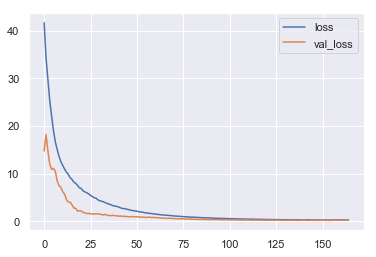

In [33]:
pd.DataFrame(train_history.history).plot()

##### Model Evaluation

In [34]:
with tf.device('/device:CPU:0'):
    deep_model.evaluate(valid_x, valid_y)

20958/20958 [==============================] - 0s 18us/sample - loss: 0.2616


#### Recommendations

In [35]:
posts.sample(20)

,post_id,title,tags
402,5469,Mendeteksi Sel Abnormal Penyebab Kanker Serviks,"[998, 999, 1000, 1001, 1002]"
2271,288566,Yang Perlu Anda Ketahui tentang Penumpukan Fos...,"[1, 4, 95, 0, 0]"
2968,510531,Temukan Manfaat Petroleum Jelly untuk Kulit Anda,"[2, 523, 0, 0, 0]"
2276,289729,Karsinoma Sel Skuamosa,"[1, 5, 696, 0, 0]"
3942,862724,Tanda Ovulasi Berhasil Dibuahi Sebagai Gejala ...,"[3, 449, 6, 17, 187]"
5938,1788417,Memahami Anatomi Kelenjar Payudara,"[1, 29, 69, 0, 0]"
5317,1557904,"Binge Eating Disorder: Tanda-tanda, Penyebab, ...","[1, 463, 36, 0, 0]"
2891,490597,Torsio Testis,"[1, 5, 605, 0, 0]"
5,725,Gejala Migrain,"[1, 87, 40, 0, 0]"
3748,777840,Mengenal Asidosis dan Pengobatannya,"[1, 366, 921, 0, 0]"


In [ ]:
"""
Making recommendations using our trained model is simple.
We only need to feed in a user and all books and then select the books which have the highest predicted ratings for that specific user.
"""
# Creating dataset for making recommendations
nids = dataset.nid.unique()
pred = [np.array([pid for i in range(len(nids))]), nids]
# print(pred)
predictions = deep_model.predict(pred)
predictions = np.array([a[0] for a in predictions])
recommended_ids = (-predictions).argsort()[:10]
recommendations = pd.DataFrame()
for xid in recommended_ids:
    recommendations = recommendations.append(dataset[dataset['pid'] == xid])
recommendations = recommendations.drop_duplicates(subset='pid', keep="last")
recommendations[['pid','title','ctr']]

##### See on Rating Data

In [36]:
post_id = 4656
dataset[dataset['post_id'] == post_id]

,post_id,pid,title,related_post_id,nid,related_title,related_tags,page_view
6418,4656,3755,Gejala Gangguan Bipolar,4658,6046,Penyebab Gangguan Bipolar,"[1, 241, 61, 0, 0]",295
6419,4656,3755,Gejala Gangguan Bipolar,4661,2441,Diagnosis Gangguan Bipolar,"[1, 241, 61, 0, 0]",113
6420,4656,3755,Gejala Gangguan Bipolar,78516,890,Pengertian gangguan bipolar,"[241, 0, 0, 0, 0]",68
24014,4656,3755,Gejala Gangguan Bipolar,476047,922,Kenali Penyebab dan Cara Mengatasi Mood Swing,"[1, 241, 34, 0, 0]",45
24015,4656,3755,Gejala Gangguan Bipolar,115198,4916,Penderita Gangguan Delusi Suka Meyakini yang A...,"[1, 34, 311, 192, 0]",45
40908,4656,3755,Gejala Gangguan Bipolar,509394,4158,Kenali Tiga Jenis Gangguan Kecemasan dan Gejal...,"[1, 893, 268, 34, 0]",23
40909,4656,3755,Gejala Gangguan Bipolar,660991,2023,Apakah psikosis berbahaya?,"[34, 0, 0, 0, 0]",23


##### Find Similarity based on Document to Vector

In [37]:
pid = post_id_pid[post_id]
sims = doc2vec_model.docvecs.most_similar([doc2vec_model[pid]], topn=20)
nids = [nid for nid,_ in sims]
most_similars = dataset[dataset['nid'].isin(nids)].drop_duplicates(subset='nid', keep='last')
most_similars[['related_post_id','nid','related_title','page_view']]

,related_post_id,nid,related_title,page_view
936,1162857,5663,Akathisia: Efek Samping Obat Antispikotik yang...,23
947,1552491,1776,Perbedaan Bipolar dengan Moody,23
6168,4753,1806,Penyebab Depresi,227
9166,1121,2622,Gejala Stroke,91
12712,2998,4762,Penyebab OCD (Obsessive Compulsive Disorder),23
25680,1787922,4565,Halusinasi,45
26448,1671113,2124,Tanda Kamu Mengalami Gangguan Jiwa,45
28284,4751,1042,Gejala Depresi,23
31643,4757,5979,Pengobatan Depresi,23
32455,1412796,2953,Percobaan Bunuh Diri,23


##### Scoring based on Page Click Collaborative Filtering

In [39]:
# Creating dataset for making recommendations
nids = most_similars.nid.values
pred = [np.array([pid for i in range(len(nids))]),
        nids,
        np.array([dataset[dataset.nid == nid].related_tags.values[0] for nid in nids])]
predictions = deep_model.predict(pred)
predictions = np.array([a[0] for a in predictions])
recommended_ids = (-predictions).argsort()[:20]

recommendations = pd.DataFrame()
nids = [nids[idx] for idx in recommended_ids]
for nid in nids:
    recommendations = recommendations.append(dataset[dataset['nid'] == nid])
recommendations[['related_post_id','nid','related_title','page_view']].drop_duplicates(subset='nid', keep='last')

,related_post_id,nid,related_title,page_view
40973,1376782,3814,Gangguan Panik,23
40984,934881,5449,Macam-macam Gangguan Jiwa yang Umum Terjadi,23
6168,4753,1806,Penyebab Depresi,227
28284,4751,1042,Gejala Depresi,23
31643,4757,5979,Pengobatan Depresi,23
32976,4656,3755,Gejala Gangguan Bipolar,23
947,1552491,1776,Perbedaan Bipolar dengan Moody,23
12712,2998,4762,Penyebab OCD (Obsessive Compulsive Disorder),23
26448,1671113,2124,Tanda Kamu Mengalami Gangguan Jiwa,45
32983,1671913,4312,"Ketahui Perbedaan Sedih dan Depresi, serta Pen...",23
